# Recommender System

## Part 1: Descriptive Statistics and Plots

### Installing packages

In [2]:
pip install scikit.surprise

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise import NormalPredictor
from surprise import SVD, SVDpp, NMF
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import collections
from surprise.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
from surprise import KNNWithMeans, KNNBasic, KNNWithZScore, KNNBaseline

### Read in the dataset

In [4]:
df = pd.read_csv('ratings.csv')

In [5]:
display(df.head(), df.tail())

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


,userId,movieId,rating,timestamp
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524
27753443,283228,54286,4.5,1354159718


In [6]:
# Check for missing data

percent_missing = df.isnull().sum() * 100 / len(df)
unique_users = len(df['userId'].unique())
unique_movie = len(df['movieId'].unique())
Total_observations = len(df)

print('Missing values: ' + str(round(percent_missing['rating'], 2)) + '%')
print('Unique users: ' + str(unique_users))
print('Unique movies: ' + str(unique_movie))
print('Total observations: ' + str(Total_observations))

Missing values: 0.0%
Unique users: 283228
Unique movies: 53889
Total observations: 27753444


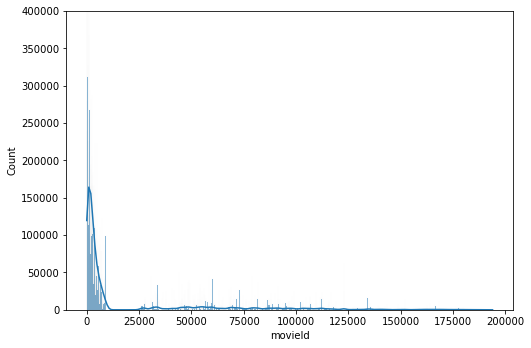

In [7]:
# Count how many times each movie is observed with a probability density function

def plot_density(df):
    fig, ax = plt.subplots(figsize=(8,5.5))
    plot = sns.histplot(df['movieId'], kde=True, ax=ax)
    plt.ylim(0,400000)
    
plot_density(df)

# we can clearly see that roughly 10.000 movies are getting almost all of the ratings

Text(0.5, 1.0, 'Number of movies rated per user')

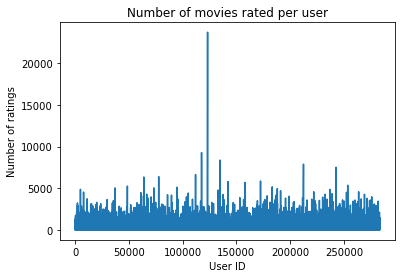

In [8]:
# Check the number of movies that each user rated
ratings_per_user = df.groupby("userId").count()["movieId"]

ax = df.groupby("userId").count()["movieId"].plot()
ax.set_ylabel("Number of ratings")
ax.set_xlabel("User ID")
ax.set_title('Number of movies rated per user')

# Disadvantage is that some users rated too many (23715 movies for one user), it is hard to show the users that rated small number of movies.

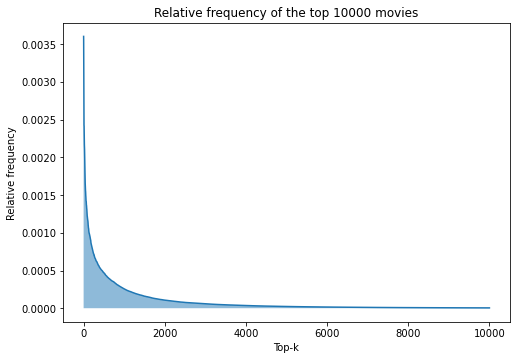

In [9]:
# Plotting the relative frequency of the top 10000 movies

def plot_frequency(df, k):
    
    fig, ax = plt.subplots(figsize=(8,5.5))
    counts = df['movieId'].value_counts(sort=True, ascending=False)
    orig = counts.index.tolist()
    counts2 = counts.reset_index(inplace=False, drop=True)
    sub = counts2.index.tolist()

    sns.lineplot(x=counts2.index[0:k], y=counts2[0:k]/counts2[0:k].sum(), ax=ax)
    ax.fill_between(counts2.index[0:k], counts2[0:k]/counts2[0:k].sum(), alpha=0.5)
    ax.set_ylabel("Relative frequency")
    ax.set_xlabel("Top-k")
    ax.set_title('Relative frequency of the top 10000 movies')

plot_frequency(df, k=10000)


In [10]:
# Showing the most and least rated movies

movie_count = df['movieId'].value_counts()
print(movie_count.head())
print(movie_count.tail())

318     97999
356     97040
296     92406
593     87899
2571    84545
Name: movieId, dtype: int64
165077    1
172453    1
192975    1
167092    1
142855    1
Name: movieId, dtype: int64


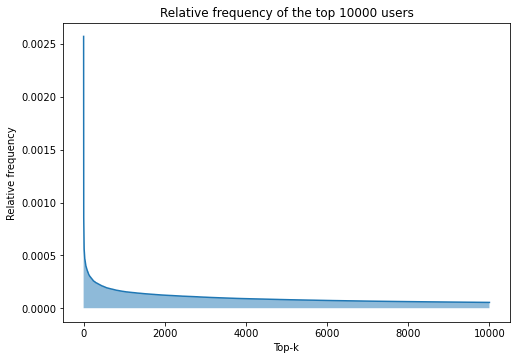

In [11]:
# Plotting the relative frequency of the top 10000 users

def plot_frequency(df, k):
    
    fig, ax = plt.subplots(figsize=(8,5.5))
    counts = df['userId'].value_counts(sort=True, ascending=False)
    orig = counts.index.tolist()
    counts2 = counts.reset_index(inplace=False, drop=True)
    sub = counts2.index.tolist()

    sns.lineplot(x=counts2.index[0:k], y=counts2[0:k]/counts2[0:k].sum(), ax=ax)
    ax.fill_between(counts2.index[0:k], counts2[0:k]/counts2[0:k].sum(), alpha=0.5)
    ax.set_ylabel("Relative frequency")
    ax.set_xlabel("Top-k")
    ax.set_title('Relative frequency of the top 10000 users')

plot_frequency(df, k=10000)

In [12]:
# Showing the users who rated the most and least number of movies

user_count = df['userId'].value_counts()
print(user_count.head())
print(user_count.tail())

123100    23715
117490     9279
134596     8381
212343     7884
242683     7515
Name: userId, dtype: int64
188125    1
117282    1
127062    1
241836    1
265726    1
Name: userId, dtype: int64


(0.0, 900000.0)

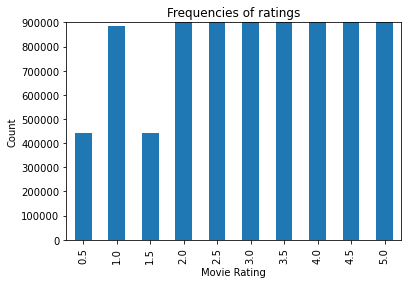

In [13]:
# Frequency for each rating

rating_count = df["rating"].value_counts().sort_index()
ax = rating_count.plot(kind="bar")
ax.set_xlabel('Movie Rating')
ax.set_ylabel('Count')
ax.set_title('Frequencies of ratings')
ax.set_ylim(0,900000)

# Most people give fours, fewest give 1.5.

In [14]:
movie_count = collections.Counter(df['movieId'])
movie_count = pd.DataFrame({'movieId':list(movie_count), 'rating': movie_count.values()}).sort_values('rating',ascending=False)
top_1_pct = round((unique_movie * 0.01))
top_1_pct
popular_1_pct = movie_count.rating[0:top_1_pct].sum()
percentage_1_pct = round(100*popular_1_pct/Total_observations)

print('The top 1% movies are responsible for ' + str(percentage_1_pct) + '% of all ratings')

# Hence we could select fewer than 5000 movies, as we are keeping many ratings and data still

The top 1% movies are responsible for 46% of all ratings


## Part 2: Data Pre-processing

In [15]:
# Checking the IQR of how many movies the users rated
user_ratings = df.groupby("movieId").count()["userId"]

user_ratings.quantile([0.25, 0.75])

0.25     2.0
0.75    48.0
Name: userId, dtype: float64

In [16]:
user_ratings.describe()

count    53889.000000
mean       515.011301
std       2934.758939
min          1.000000
25%          2.000000
50%          7.000000
75%         48.000000
max      97999.000000
Name: userId, dtype: float64

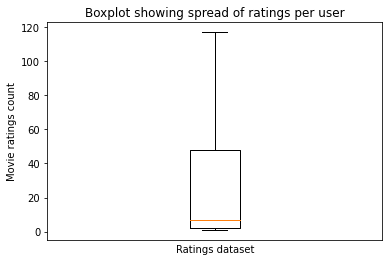

In [17]:
# Boxplot

plt.boxplot(user_ratings, showfliers=False)
plt.xlabel('Ratings dataset')
plt.ylabel('Movie ratings count')
plt.title('Boxplot showing spread of ratings per user')
plt.tick_params(axis='x', which='both', bottom=False,labelbottom=False)

In [18]:
# Cutting users who rated more than 48 or less than 2 movies

user_counts = df['userId'].value_counts()
to_remove = user_counts[user_counts > 48].index
df = df[~df['userId'].isin(to_remove)]

new_movie_count = df['userId'].value_counts()

In [19]:
user_counts = df['userId'].value_counts()
to_remove = user_counts[user_counts < 2].index
df = df[~df['userId'].isin(to_remove)]

new_movie_count = df['userId'].value_counts()

In [20]:
user_counts = df['userId'].value_counts()
print(user_counts.head())
print(user_counts.tail())

100415    48
255429    48
253645    48
25571     48
158855    48
Name: userId, dtype: int64
156099    2
182568    2
234349    2
156087    2
102447    2
Name: userId, dtype: int64


In [21]:
# Descriptive statistics of updated dataset

unique_users = len(df['userId'].unique())
unique_movie = len(df['movieId'].unique())
Total_observations = len(df)

print('Unique users: ' + str(unique_users))
print('Unique movies: ' + str(unique_movie))
print('Total observations: ' + str(Total_observations))

print(df.shape, df.size)
print(df.head())

Unique users: 166662
Unique movies: 19071
Total observations: 3186498
(3186498, 4) 12745992
   userId  movieId  rating   timestamp
0       1      307     3.5  1256677221
1       1      481     3.5  1256677456
2       1     1091     1.5  1256677471
3       1     1257     4.5  1256677460
4       1     1449     4.5  1256677264


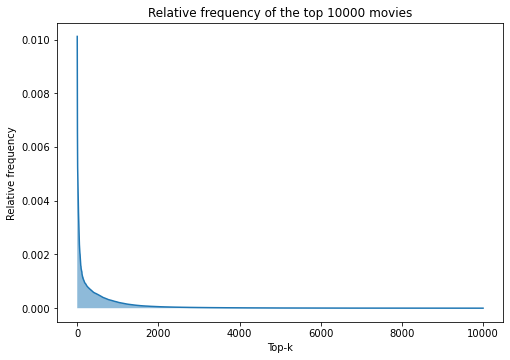

In [22]:
def plot_frequency(df, k):
    
    fig, ax = plt.subplots(figsize=(8,5.5))
    counts = df['movieId'].value_counts(sort=True, ascending=False)
    orig = counts.index.tolist()
    counts2 = counts.reset_index(inplace=False, drop=True)
    sub = counts2.index.tolist()

    sns.lineplot(x=counts2.index[0:k], y=counts2[0:k]/counts2[0:k].sum(), ax=ax)
    ax.fill_between(counts2.index[0:k], counts2[0:k]/counts2[0:k].sum(), alpha=0.5)
    ax.set_ylabel("Relative frequency")
    ax.set_xlabel("Top-k")
    ax.set_title('Relative frequency of the top 10000 movies')

plot_frequency(df, k=10000)

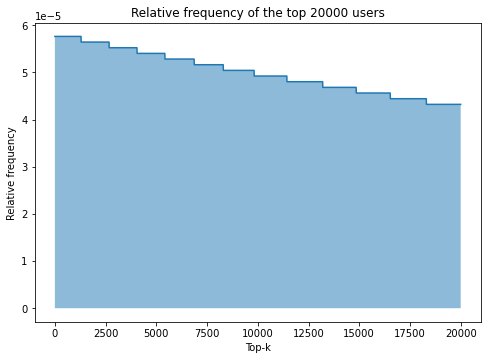

In [23]:
def plot_frequency(df, k):
    
    fig, ax = plt.subplots(figsize=(8,5.5))
    counts = df['userId'].value_counts(sort=True, ascending=False)
    orig = counts.index.tolist()
    counts2 = counts.reset_index(inplace=False, drop=True)
    sub = counts2.index.tolist()

    sns.lineplot(x=counts2.index[0:k], y=counts2[0:k]/counts2[0:k].sum(), ax=ax)
    ax.fill_between(counts2.index[0:k], counts2[0:k]/counts2[0:k].sum(), alpha=0.5)
    ax.set_ylabel("Relative frequency")
    ax.set_xlabel("Top-k")
    ax.set_title('Relative frequency of the top 20000 users')

plot_frequency(df, k=20000)

Text(0.5, 1.0, 'Frequencies of ratings')

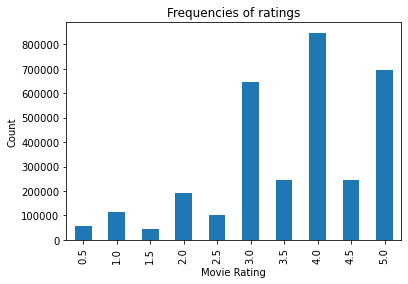

In [24]:
rating_count = df["rating"].value_counts().sort_index()
ax = rating_count.plot(kind="bar")
ax.set_xlabel('Movie Rating')
ax.set_ylabel('Count')
ax.set_title('Frequencies of ratings')

In [25]:
# Selecting top-k movies to run models on

def select(df, k, col): 

    top_values = df[col].value_counts().nlargest(k)
    return df.loc[df[col].isin(top_values.index)]

In [26]:
# Descriptives of final dataset to be used

df1 = select(df, k=250, col='movieId')  

user_number = len(df1["userId"].unique())
movie_number = len(df1["movieId"].unique())

print('Number of Users: ' + str(user_number))
print('Number of Movies: ' + str(movie_number))
print('Total observations: ' + str(Total_observations))

print(df1.shape, df1.size)
print(df.head())

Number of Users: 146509
Number of Movies: 250
Total observations: 3186498
(1479475, 4) 5917900
   userId  movieId  rating   timestamp
0       1      307     3.5  1256677221
1       1      481     3.5  1256677456
2       1     1091     1.5  1256677471
3       1     1257     4.5  1256677460
4       1     1449     4.5  1256677264


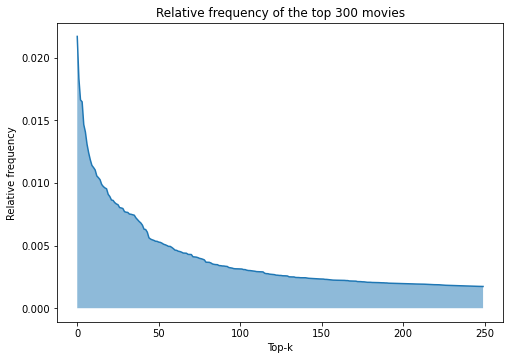

In [27]:
def plot_frequency(df, k):
    
    fig, ax = plt.subplots(figsize=(8,5.5))
    counts = df1['movieId'].value_counts(sort=True, ascending=False)
    orig = counts.index.tolist()
    counts2 = counts.reset_index(inplace=False, drop=True)
    sub = counts2.index.tolist()

    sns.lineplot(x=counts2.index[0:k], y=counts2[0:k]/counts2[0:k].sum(), ax=ax)
    ax.fill_between(counts2.index[0:k], counts2[0:k]/counts2[0:k].sum(), alpha=0.5)
    ax.set_ylabel("Relative frequency")
    ax.set_xlabel("Top-k")
    ax.set_title('Relative frequency of the top 300 movies')

plot_frequency(df, k=300)

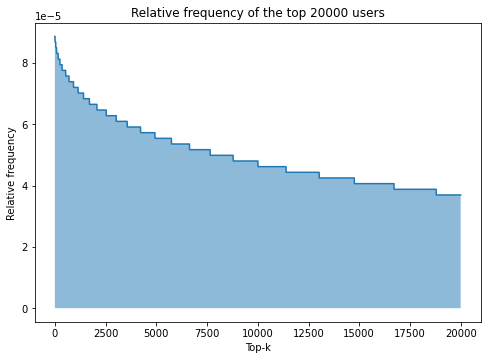

In [28]:
def plot_frequency(df, k):
    
    fig, ax = plt.subplots(figsize=(8,5.5))
    counts = df1['userId'].value_counts(sort=True, ascending=False)
    orig = counts.index.tolist()
    counts2 = counts.reset_index(inplace=False, drop=True)
    sub = counts2.index.tolist()

    sns.lineplot(x=counts2.index[0:k], y=counts2[0:k]/counts2[0:k].sum(), ax=ax)
    ax.fill_between(counts2.index[0:k], counts2[0:k]/counts2[0:k].sum(), alpha=0.5)
    ax.set_ylabel("Relative frequency")
    ax.set_xlabel("Top-k")
    ax.set_title('Relative frequency of the top 20000 users')

plot_frequency(df, k=20000)

Text(0.5, 1.0, 'Frequencies of ratings')

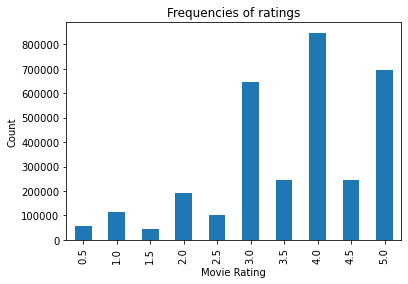

In [29]:
rating_count = df["rating"].value_counts().sort_index()
ax = rating_count.plot(kind="bar")
ax.set_xlabel('Movie Rating')
ax.set_ylabel('Count')
ax.set_title('Frequencies of ratings')

In [30]:
# Prepare data for running algorithms
# Drop timestamp column as this does not contribute much

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df1[['userId', 'movieId', 'rating']], reader)



As we can see from the graphs above the dataset is very top-heavy. That is the 'top' movies recieve an overwhelming ammount of ratings. So much so that the top 1% of movies account for 46% of the ratings. Focussing on the 'top' movies allows us to capture a lot of information of the dataset. It also makes sense to recommend movies that are already popular in terms of number of ratings. This indicates that people feel strongly about those movies and that they are getting watched a lot already. As was shown from the boxplot there are a lot of outliers regarding the users. Some users only rated 1 movie while others rated thousands. This really skews the mean. We decided to cut the bottom 25% percent (users that only rated 0 or 1 movies) and we cut the top 25% (users that rated more than 48 movies). This is in order to better approximate the 'avarage' user. 


## Part 3: Model Testing

## Baseline Model - Normal Predictor

In [31]:
# Cross validation with baseline predictor
import time

start = time.time()
norm_pred = cross_validate(NormalPredictor(), data, cv=5, return_train_measures=True)
end = time.time()
time_it_took_norm = end-start
print('Time to run: ' + str(time_it_took_norm))

Time to run: 95.72892332077026


In [32]:
norm_pred = pd.DataFrame.from_dict(norm_pred)
folds = [1,2,3,4,5]
norm_pred = norm_pred.assign(Fold = folds)
norm_pred = norm_pred.set_index('Fold').sort_values(by=['test_rmse'])
display(norm_pred)

,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
Fold,,,,,,
4,1.428514,1.431515,1.132894,1.134789,2.221971,2.049284
1,1.429718,1.430461,1.132606,1.133614,1.717977,2.491152
3,1.429994,1.430192,1.133665,1.132917,2.197474,2.505799
2,1.431590,1.430158,1.134689,1.133640,2.374519,2.756002
5,1.432227,1.429900,1.136025,1.133121,2.135047,2.928950


In [33]:
print("Baseline model's best performance: " + str(norm_pred['test_rmse'].min()))

Baseline model's best performance: 1.428514429545212


## Hyper-parameter selecting method selection:

For hyper-parameter selecting method selection, we prepared 2 options, grid search and randomized search. To distinguish the better method, we tested both of them by coding and searched for a reference paper which analyzed these 2 methods. On the same computer, grid search took 86 minutes, randomized search only took 55 minutes. From the research of James and Yoshua (resource: https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf), they announced that random search can find better hyper-parameter combination for most cases, and take less running time by comparing with grid search. Based on these 2 aspects, we choose randomized search as the hyper-parameter selecting method.


## First Model - Neighbourhood Method

In [98]:
# Parameter grid

param_grid = {'k': [5,7,9,11,13,15,17,19],
              'sim_options': {'name': [ 'pearson','pearson_baseline'],
                              'min_support': [1,3,5],
                              'user_based': [False]},
              'verbose':[False]}

In [99]:
# Function to run hp tuning and output a table of results

best_knn_results_df = pd.DataFrame()

def knn_model_hp_tune(model, param_grid):
    global best_knn_results_df
    model_results = pd.DataFrame()
    result = RandomizedSearchCV(model, param_grid, cv=5, return_train_measures=True)
    result.fit(data)
    model_results = pd.DataFrame.from_dict(result.cv_results)
    model_results = model_results[['mean_test_rmse', 'mean_train_rmse', 'mean_test_mae', 'mean_train_mae', 
                   'mean_fit_time', 'mean_test_time', 'params']]
    labels = [model.__name__]*model_results.shape[0]
    model_results = model_results.assign(Model = labels).set_index('Model')
    model_results = model_results.sort_values('mean_test_rmse')
    best_knn_results_df = best_knn_results_df.append(model_results.iloc[0])
    return model_results
    

In [100]:
pd.set_option("max_colwidth", 120)

In [104]:
# Hp tuning on KNN-Baseline model

import time
np.random.seed(2)

start = time.time()

knn_baseline_hp_df = knn_model_hp_tune(KNNBaseline, param_grid)

end = time.time()
time_it_took_baseline = end-start
print('Time to run: ' + str(time_it_took_baseline))

Time to run: 2467.556744813919


In [105]:
knn_baseline_hp_df

,mean_test_rmse,mean_train_rmse,mean_test_mae,mean_train_mae,mean_fit_time,mean_test_time,params
Model,,,,,,,
KNNBaseline,0.915994,0.516039,0.689317,0.385057,4.419241,8.232495,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 5, 'user_based': False}, 'verbose': False}"
KNNBaseline,0.916075,0.516115,0.689388,0.385132,3.818455,8.991826,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 3, 'user_based': False}, 'verbose': False}"
KNNBaseline,0.916096,0.516137,0.689414,0.385148,4.576236,9.655310,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 1, 'user_based': False}, 'verbose': False}"
KNNBaseline,0.916327,0.555184,0.691417,0.414334,4.735301,8.996859,"{'k': 19, 'sim_options': {'name': 'pearson', 'min_support': 3, 'user_based': False}, 'verbose': False}"
KNNBaseline,0.916345,0.555203,0.691439,0.414348,4.023512,8.488016,"{'k': 19, 'sim_options': {'name': 'pearson', 'min_support': 1, 'user_based': False}, 'verbose': False}"
KNNBaseline,0.925309,0.447415,0.693054,0.331846,4.462475,7.692730,"{'k': 5, 'sim_options': {'name': 'pearson', 'min_support': 1, 'user_based': False}, 'verbose': False}"
KNNBaseline,0.929904,0.288613,0.689144,0.198836,4.267021,8.366417,"{'k': 19, 'sim_options': {'name': 'pearson_baseline', 'min_support': 3, 'user_based': False}, 'verbose': False}"
KNNBaseline,0.929911,0.287938,0.689131,0.198460,4.446751,8.200993,"{'k': 15, 'sim_options': {'name': 'pearson_baseline', 'min_support': 5, 'user_based': False}, 'verbose': False}"
KNNBaseline,0.930110,0.284610,0.689203,0.196481,5.220586,8.916044,"{'k': 11, 'sim_options': {'name': 'pearson_baseline', 'min_support': 5, 'user_based': False}, 'verbose': False}"


In [106]:
# Hp tuning on KNN with Means model

import time
np.random.seed(2)

start = time.time()

knn_means_hp_df = knn_model_hp_tune(KNNWithMeans, param_grid)

end = time.time()
time_it_took_means = end-start
print('Time to run: ' + str(time_it_took_means))

Time to run: 2021.2970623970032


In [107]:
knn_means_hp_df

,mean_test_rmse,mean_train_rmse,mean_test_mae,mean_train_mae,mean_fit_time,mean_test_time,params
Model,,,,,,,
KNNWithMeans,0.919076,0.516463,0.691719,0.385467,1.848789,7.314214,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 5, 'user_based': False}, 'verbose': False}"
KNNWithMeans,0.919159,0.516541,0.691791,0.385542,1.753985,7.104483,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 3, 'user_based': False}, 'verbose': False}"
KNNWithMeans,0.919181,0.516563,0.691818,0.385559,1.720051,7.202333,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 1, 'user_based': False}, 'verbose': False}"
KNNWithMeans,0.919436,0.555653,0.693873,0.414815,1.756475,7.887719,"{'k': 19, 'sim_options': {'name': 'pearson', 'min_support': 3, 'user_based': False}, 'verbose': False}"
KNNWithMeans,0.919455,0.555672,0.693896,0.414829,1.720835,7.382070,"{'k': 19, 'sim_options': {'name': 'pearson', 'min_support': 1, 'user_based': False}, 'verbose': False}"
KNNWithMeans,0.928376,0.447804,0.695410,0.332179,1.630272,6.672109,"{'k': 5, 'sim_options': {'name': 'pearson', 'min_support': 1, 'user_based': False}, 'verbose': False}"
KNNWithMeans,0.933166,0.288795,0.691574,0.198994,4.596944,5.949509,"{'k': 19, 'sim_options': {'name': 'pearson_baseline', 'min_support': 3, 'user_based': False}, 'verbose': False}"
KNNWithMeans,0.933175,0.288118,0.691563,0.198618,4.527300,6.437486,"{'k': 15, 'sim_options': {'name': 'pearson_baseline', 'min_support': 5, 'user_based': False}, 'verbose': False}"
KNNWithMeans,0.933373,0.284785,0.691634,0.196635,5.057280,7.552534,"{'k': 11, 'sim_options': {'name': 'pearson_baseline', 'min_support': 5, 'user_based': False}, 'verbose': False}"


In [108]:
# Hp tuning on KNN with Z-score model

import time
np.random.seed(2)

start = time.time()

knn_zscore_hp_df = knn_model_hp_tune(KNNWithZScore, param_grid)

end = time.time()
time_it_took_zscore = end-start
print('Time to run: ' + str(time_it_took_zscore))

Time to run: 2049.4776413440704


In [109]:
knn_zscore_hp_df

,mean_test_rmse,mean_train_rmse,mean_test_mae,mean_train_mae,mean_fit_time,mean_test_time,params
Model,,,,,,,
KNNWithZScore,0.920302,0.516526,0.691984,0.385388,2.312638,6.857675,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 5, 'user_based': False}, 'verbose': False}"
KNNWithZScore,0.920380,0.516603,0.692054,0.385464,2.273148,7.150002,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 3, 'user_based': False}, 'verbose': False}"
KNNWithZScore,0.920406,0.516625,0.692081,0.385480,2.553584,7.270317,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 1, 'user_based': False}, 'verbose': False}"
KNNWithZScore,0.920645,0.555691,0.694199,0.414783,2.355047,7.640504,"{'k': 19, 'sim_options': {'name': 'pearson', 'min_support': 3, 'user_based': False}, 'verbose': False}"
KNNWithZScore,0.920668,0.555710,0.694223,0.414797,2.348368,7.448239,"{'k': 19, 'sim_options': {'name': 'pearson', 'min_support': 1, 'user_based': False}, 'verbose': False}"
KNNWithZScore,0.929659,0.447912,0.695645,0.332069,2.336987,6.779240,"{'k': 5, 'sim_options': {'name': 'pearson', 'min_support': 1, 'user_based': False}, 'verbose': False}"
KNNWithZScore,0.934078,0.288683,0.691716,0.198937,4.902075,6.127139,"{'k': 19, 'sim_options': {'name': 'pearson_baseline', 'min_support': 3, 'user_based': False}, 'verbose': False}"
KNNWithZScore,0.934083,0.288005,0.691702,0.198559,4.866825,6.531915,"{'k': 15, 'sim_options': {'name': 'pearson_baseline', 'min_support': 5, 'user_based': False}, 'verbose': False}"
KNNWithZScore,0.934277,0.284673,0.691772,0.196573,6.742850,7.769959,"{'k': 11, 'sim_options': {'name': 'pearson_baseline', 'min_support': 5, 'user_based': False}, 'verbose': False}"


In [110]:
# Displaying the best result for each of the models

display(best_knn_results_df.sort_values('mean_test_rmse'))

,mean_test_rmse,mean_train_rmse,mean_test_mae,mean_train_mae,mean_fit_time,mean_test_time,params
KNNBaseline,0.915994,0.516039,0.689317,0.385057,4.419241,8.232495,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 5, 'user_based': False}, 'verbose': False}"
KNNWithMeans,0.919076,0.516463,0.691719,0.385467,1.848789,7.314214,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 5, 'user_based': False}, 'verbose': False}"
KNNWithZScore,0.920302,0.516526,0.691984,0.385388,2.312638,6.857675,"{'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 5, 'user_based': False}, 'verbose': False}"


In [111]:
best_knn_results_model = best_knn_results_df.iloc[0]
best_score = best_knn_results_model['mean_test_rmse']
print('Best sore: ' + str(best_score))
best_params = best_knn_results_model['params']
print('Best params: ' + str(best_params))

Best sore: 0.9159936251685419
Best params: {'k': 9, 'sim_options': {'name': 'pearson', 'min_support': 5, 'user_based': False}, 'verbose': False}


In [112]:
# Creating the optimal knn model

nn = best_params['k']
print('Optimal number of neighbours: ' + str(nn))
name = best_params['sim_options']['name']
print('Optimal distance measure: ' + str(name))
ms = best_params['sim_options']['min_support']
print('Optimal minimum support: ' + str(ms))

Optimal number of neighbours: 9
Optimal distance measure: pearson
Optimal minimum support: 5


In [113]:
knn = KNNBaseline(k=nn, sim_options = {'name':name, 'user_based':False, 'min_support':ms}, verbose=False)

In [114]:
# Cross validation with optimised knn model
import time

start = time.time()
knn_cv= cross_validate(knn, data, cv=5, return_train_measures=True)
end = time.time()
time_it_took_cv = end-start
print('Time to run: ' + str(time_it_took_cv))

Time to run: 229.83649396896362


In [115]:
knn_cv_df = pd.DataFrame.from_dict(knn_cv)
folds = [1,2,3,4,5]
knn_cv_df = knn_cv_df.assign(Fold = folds)
knn_cv_df = knn_cv_df.set_index('Fold').sort_values(by=['test_rmse'])
knn_cv_df

,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
Fold,,,,,,
1,0.914301,0.515958,0.688840,0.384942,4.232399,7.791834
3,0.915523,0.515861,0.689422,0.384880,4.782850,7.463417
4,0.915692,0.516094,0.688284,0.385183,4.587320,7.479719
2,0.917641,0.515821,0.690614,0.384849,4.429986,8.228285
5,0.918315,0.516225,0.691128,0.385273,4.484810,7.931176


In [116]:
print("KNN Baseline's best performance: " + str(knn_cv_df['test_rmse'].min()))

KNN Baseline's best performance: 0.914300500291923


## Second Model - Matrix Factorisation-Based Method

## Matrix factorization-based algorithm selection

Firstly, we selected all 3 matrix factorization-based algorithms from the surprise package document, which are SVD, SVDpp, NMF. Secondly, we tested these 3 algorithms using a limited dataset and default hyper-parameters. SVD took 3.35 minutes with the best test rmse 0.9148, SVDpp took 6.52 minutes with the best test rmse 0.8954, NMF took 4.28 minutes with the best test rmse 0.9949. We decided to use the SVD algorithm, because SVDpp’s performance is only slightly better than SVD, but it took much longer time, NMF’s performance is worse than SVD and took longer time.


In [49]:
# part 1 algorithm selection

# SVD

start = time.time()
svd_as = cross_validate(SVD(),data, cv=5 , return_train_measures = True)
end = time.time()
time_it_took_svd = end-start
print('Time to run: ' + str(time_it_took_svd))

Time to run: 201.46788334846497


In [50]:
svd_cv_df = pd.DataFrame.from_dict(svd_as)
folds = [1,2,3,4,5]
svd_cv_df = svd_cv_df.assign(Fold = folds)
svd_cv_df = svd_cv_df.set_index('Fold').sort_values(by=['test_rmse'])
svd_cv_df

,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
Fold,,,,,,
4,0.914670,0.642009,0.706795,0.497180,15.315280,4.437111
3,0.915224,0.643279,0.706928,0.497958,15.379680,4.145399
5,0.916910,0.643106,0.707211,0.497258,15.718511,3.606954
2,0.917481,0.642120,0.708643,0.497535,15.458980,4.343551
1,0.918515,0.641404,0.709158,0.495851,14.976897,5.156003


In [51]:
# SVDpp

start = time.time()
svdpp_as = cross_validate(SVDpp(),data, cv=5 , return_train_measures = True)
end = time.time()
time_it_took_pp = end-start
print('Time to run: ' + str(time_it_took_pp))

Time to run: 391.9271340370178


In [52]:
svdpp_cv_df = pd.DataFrame.from_dict(svdpp_as)
folds = [1,2,3,4,5]
svdpp_cv_df = svdpp_cv_df.assign(Fold = folds)
svdpp_cv_df = svdpp_cv_df.set_index('Fold').sort_values(by=['test_rmse'])
svdpp_cv_df

,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
Fold,,,,,,
2,0.895419,0.624773,0.686207,0.476906,27.795355,10.438234
4,0.895562,0.625077,0.687279,0.477544,28.712260,9.866961
5,0.896354,0.623974,0.689538,0.478648,28.694185,9.726893
3,0.897857,0.624672,0.689046,0.477985,27.871529,9.213713
1,0.898839,0.624271,0.689968,0.478325,28.455654,9.604678


In [53]:
# NMF

start = time.time()
nmf_as = cross_validate(NMF(),data, cv=5 , return_train_measures = True)
end = time.time()
time_it_took_nmf = end-start
print('Time to run: ' + str(time_it_took_nmf))

Time to run: 256.9314925670624


In [54]:
nmf_cv_df = pd.DataFrame.from_dict(nmf_as)
folds = [1,2,3,4,5]
nmf_cv_df = nmf_cv_df.assign(Fold = folds)
nmf_cv_df = nmf_cv_df.set_index('Fold').sort_values(by=['test_rmse'])
nmf_cv_df

,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
Fold,,,,,,
3,0.994863,0.540448,0.762312,0.389254,28.066735,3.528540
5,0.996441,0.542619,0.763289,0.391693,28.672009,3.745545
1,0.996527,0.540857,0.763359,0.389604,28.034776,3.970182
2,0.996639,0.536995,0.765158,0.388385,30.412653,4.983305
4,1.001741,0.541598,0.768894,0.390157,28.115631,3.070997


In [55]:
best_mf_models_df = pd.DataFrame()
best_mf_models_df = best_mf_models_df.append([svd_cv_df.iloc[0], svdpp_cv_df.iloc[0], nmf_cv_df.iloc[0]])
models = ['SVD','SVD pp','NMF']
best_mf_models_df = best_mf_models_df.assign(Model=models).set_index('Model').sort_values(by=['test_rmse'])
display(best_mf_models_df)

,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
Model,,,,,,
SVD pp,0.895419,0.624773,0.686207,0.476906,27.795355,10.438234
SVD,0.914670,0.642009,0.706795,0.497180,15.315280,4.437111
NMF,0.994863,0.540448,0.762312,0.389254,28.066735,3.528540


## SVD model hyper-parameter tuning:

Motivation:
We found one reference paper to help on hyper parameter tuning (resource: https://arxiv.org/abs/1710.00482). According to this research paper, we selected the number of epochs and learning rate for hyper parameter tuning . This research paper pointed out that when the number of  epochs changes from 10 to 20, the rmse decreases dramatically, after 30 the rmse only slightly increases. Therefore, we set the list of the number of epochs as 5, 10, 20, 30. For learning rate, the recommended learning rate is 0.005, based on this number ,we set the list of learning rate as 0.0025, 0.005, 0.001, 0.01.

Tuning output:
After running the SVD hyper-parameter tuning with the top-250 data and randomized search method, the best hyper-parameter combination is 30 epochs and 0.01 learning rate with the best rmse stands for 0.9125, which took 3.9 minutes.



In [56]:
# hyper-parameter tuning

parameterset = {'n_epochs': [5, 10, 20, 30],  # refer paper pointed out epoch change from 10 to 20, the rmse decreases dramatically, after 30 epoch the difference of rmse is small.  
        'lr_all': [.0025, .005, .001, .01]} # recommendation of learning rate is 0.005, we set up a group of learning rate basing on 0.005 to test the best learning rate

In [57]:
svd_tune = RandomizedSearchCV(SVD, parameterset, cv=5, return_train_measures=True)
svd_tune.fit(data)

In [58]:
svd_hp = pd.DataFrame.from_dict(svd_tune.cv_results)
svd_hp = svd_hp[['mean_test_rmse', 'mean_train_rmse', 'mean_test_mae', 'mean_train_mae', 
                   'mean_fit_time', 'mean_test_time', 'params']]
label = ['SVD']*svd_hp.shape[0]
svd_hp = svd_hp.assign(Model = label).set_index('Model')
svd_hp = svd_hp.sort_values('mean_test_rmse')
svd_hp

,mean_test_rmse,mean_train_rmse,mean_test_mae,mean_train_mae,mean_fit_time,mean_test_time,params
Model,,,,,,,
SVD,0.915053,0.252089,0.700999,0.189925,21.366019,4.466404,"{'n_epochs': 30, 'lr_all': 0.01}"
SVD,0.917369,0.641799,0.708382,0.496825,15.003116,5.701776,"{'n_epochs': 20, 'lr_all': 0.005}"
SVD,0.918915,0.657906,0.709301,0.508915,7.210301,4.282594,"{'n_epochs': 10, 'lr_all': 0.01}"
SVD,0.919068,0.740907,0.712478,0.577319,21.171579,4.914808,"{'n_epochs': 30, 'lr_all': 0.0025}"
SVD,0.928614,0.839631,0.722581,0.655368,14.536611,5.517920,"{'n_epochs': 20, 'lr_all': 0.0025}"
SVD,0.940536,0.894586,0.733292,0.698258,21.145339,4.603142,"{'n_epochs': 30, 'lr_all': 0.001}"
SVD,0.948118,0.911918,0.738826,0.711170,3.926956,4.511291,"{'n_epochs': 5, 'lr_all': 0.005}"
SVD,0.950128,0.919744,0.741322,0.717986,14.312119,4.569597,"{'n_epochs': 20, 'lr_all': 0.001}"
SVD,0.963401,0.946526,0.752193,0.739180,9.022463,5.766630,"{'n_epochs': 10, 'lr_all': 0.001}"


In [59]:
best_svd_hp = svd_hp.iloc[0]
best_score = best_svd_hp['mean_test_rmse']
print('Best sore: ' + str(best_score))
best_params = best_svd_hp['params']
print('Best params: ' + str(best_params))

Best sore: 0.9150528018831035
Best params: {'n_epochs': 30, 'lr_all': 0.01}


In [60]:
n_epochs = best_params['n_epochs']
print('Optimal number of epochs: ' + str(n_epochs))
lr_all = best_params['lr_all']
print('Optimal learning rate for all parameters: ' + str(lr_all))

Optimal number of epochs: 30
Optimal learning rate for all parameters: 0.01


In [61]:
# Cross validation with tuned SVD model
import time

start = time.time()
svd_cv= cross_validate(SVD(n_epochs=n_epochs, lr_all=lr_all), data, cv=5, return_train_measures=True)
end = time.time()
time_it_took_cv = end-start
print('Time to run: ' + str(time_it_took_cv))

Time to run: 233.69311809539795


In [62]:
svd_cv_df = pd.DataFrame.from_dict(svd_cv)
folds = [1,2,3,4,5]
svd_cv_df = svd_cv_df.assign(Fold = folds)
svd_cv_df = svd_cv_df.set_index('Fold').sort_values(by=['test_rmse'])
svd_cv_df

,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
Fold,,,,,,
5,0.912494,0.254106,0.699368,0.191167,22.332648,3.701203
1,0.913596,0.252138,0.699840,0.189521,22.016915,5.040142
4,0.914483,0.252735,0.700847,0.190419,22.267496,4.750336
3,0.916405,0.253789,0.702177,0.191472,22.080474,3.755780
2,0.916670,0.251567,0.702834,0.189838,22.352987,4.519484


In [63]:
print("SVD model's best performance: " + str(svd_cv_df['test_rmse'].min()))

SVD model's best performance: 0.9124944831009787


## Summary of the best model results

In [117]:
compare_best_models_df = pd.DataFrame()
compare_best_models_df = compare_best_models_df.append([norm_pred.iloc[0], knn_cv_df.iloc[0], svd_cv_df.iloc[0]])
models = ['Normal Predictor','KNN Baseline','SVD']
compare_best_models_df = compare_best_models_df.assign(Model=models).set_index('Model').sort_values(by=['test_rmse'])
display(compare_best_models_df)

,test_rmse,train_rmse,test_mae,train_mae,fit_time,test_time
Model,,,,,,
SVD,0.912494,0.254106,0.699368,0.191167,22.332648,3.701203
KNN Baseline,0.914301,0.515958,0.688840,0.384942,4.232399,7.791834
Normal Predictor,1.428514,1.431515,1.132894,1.134789,2.221971,2.049284


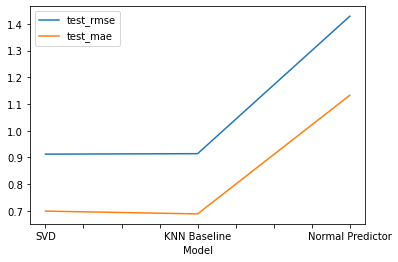

In [118]:
ax = compare_best_models_df[['test_rmse','test_mae']].plot()